In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from src.models.layers import get_activation, GraphConvBlock
from src.datasets.utils import normalize_adjacency, remove_self_loops
from src.plot import plot_dynamic_graph

In [2]:
data_path = "../data/data.npz"
num_samples = 20

hidden_dim = 128   

batch_size = 5
num_epochs = 500
learning_rate = 1e-3

In [3]:
data_dic = dict(np.load(data_path, allow_pickle=True).items())
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data_dic["X"]).float(), torch.from_numpy(data_dic["A"]).float())
node_dim = dataset.tensors[0].shape[-1]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
class Encoder(nn.Module):
    """Encoder for computing node-wise latent variables."""

    def __init__(self, input_dim, hidden_dim, activation=None, batch_norm=True, dropout=0.):

        super(Encoder, self).__init__()

        self.gconv1 = GraphConvBlock(input_dim, hidden_dim * 2, batch_norm=batch_norm, activation=activation, dropout=dropout)
        self.gconv2 = GraphConvBlock(hidden_dim * 2, hidden_dim, batch_norm=batch_norm, activation=activation, dropout=dropout)

    def forward(self, X, A):
        
        H = self.gconv1(X, A)
        Z = self.gconv2(H, A)

        return Z


class Decoder(nn.Module):
    """Decoder for computing edge probabilities."""

    def __init__(self, activation=None, dropout=0.):

        super(Decoder, self).__init__()

        self.activation = get_activation(activation)


    def forward(self, H):

        A = self.activation(H.bmm(H.transpose(-2, -1)))

        return A

In [5]:
encoder = Encoder(node_dim, hidden_dim, activation=None)
decoder = Decoder(activation=None)

In [6]:
optimizer = torch.optim.Adam(list(list(encoder.parameters()) + list(decoder.parameters())), lr=learning_rate)

In [7]:
X, A  = next(iter(dataloader))

A = A.reshape(-1, *A.shape[2:]) 
X = X.reshape(-1, *X.shape[2:]) 



In [8]:
loss_results = []

for epoch in range(num_epochs):

    encoder.train()
    decoder.train()

    epoch_loss = 0

    for X, A  in dataloader:

        # B x T x N x D -> BT x N x D
        X = X.reshape(-1, *X.shape[2:]) 
        # B x T x N x N -> BT x N x N
        A = A.reshape(-1, *A.shape[2:]) 
        A_norm = normalize_adjacency(A)
        A_norm = remove_self_loops(A)

        # num non edges / num edges
        pos_weight = ((A.shape[-1] ** 2  - A.sum(dim=(-2, -1))) / A.sum(dim=(-2, -1))).unsqueeze(-1).unsqueeze(-1)
        # num possible edges / num non edges
        norm = (A.shape[-1] **2 / (A.shape[-1]**2 - A.sum(dim=(-2, -1)))).unsqueeze(-1).unsqueeze(-1)

        
        optimizer.zero_grad()
        A_recon = decoder(encoder(X, A_norm))
        loss = norm * F.binary_cross_entropy_with_logits(A_recon, A, pos_weight=pos_weight, reduction="none")
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() / len(dataloader)

    loss_results += [epoch_loss]

    if epoch % 100 == 0:
        print("epoch {:4d} | loss {:06.4f}".format(epoch, round(loss_results[-1], 2)))

epoch    0 | loss 33.8700
epoch  100 | loss 8.2600
epoch  200 | loss 3.2300
epoch  300 | loss 1.3000
epoch  400 | loss 0.8500


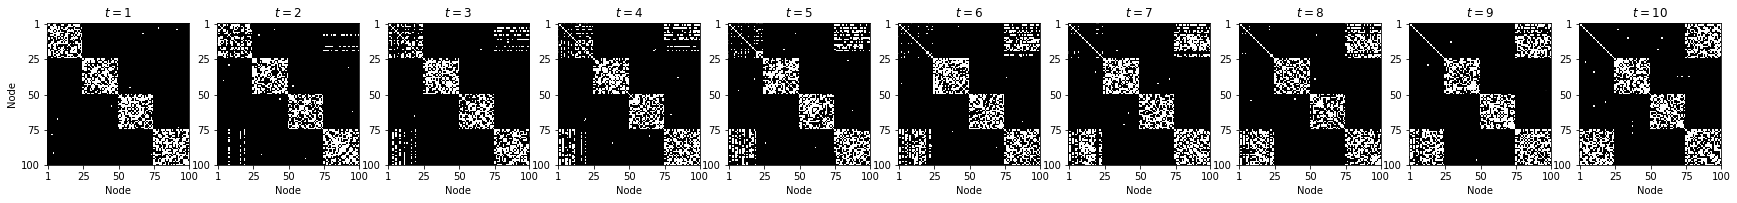

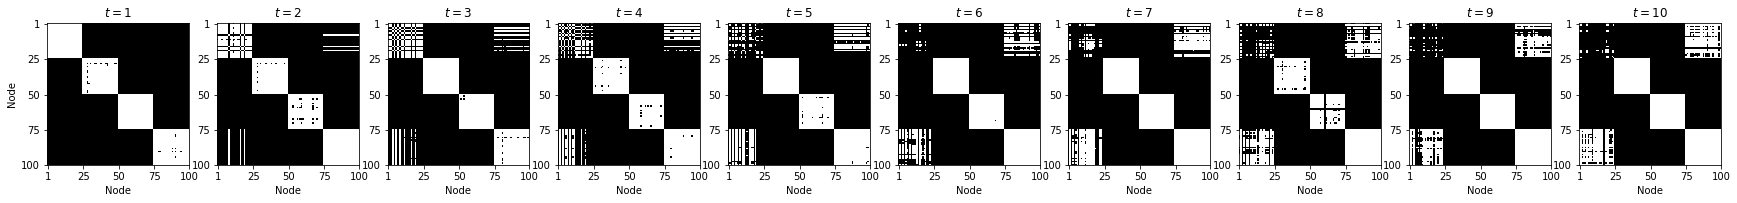

In [12]:
X, A  = next(iter(dataloader))

X = X.reshape(-1, *X.shape[2:]) 
A = A.reshape(-1, *A.shape[2:]) 

A_recon = decoder(encoder(X, A))

A = A.reshape(batch_size, -1, node_dim, node_dim).detach().numpy()
A_recon = A_recon.reshape(batch_size, -1, node_dim, node_dim).detach().sigmoid().numpy()

idx = np.random.choice(batch_size, 1)[0]

plot_dynamic_graph(A[idx])
plot_dynamic_graph(A_recon[idx]> 0.8)